**Requirements:**
* Trained models

**Outputs:** 
* none 
___
# Imports

In [32]:
import matplotlib
import umap.plot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sn

from compert.paths import FIGURE_DIR
from utils import load_config, load_dataset, load_smiles, load_model, compute_drug_embeddings, compute_pred

matplotlib.style.use("fivethirtyeight")
matplotlib.style.use("seaborn-talk")
matplotlib.rcParams['font.family'] = "monospace"
matplotlib.rcParams['figure.dpi'] = 200
matplotlib.pyplot.rcParams['savefig.facecolor'] = 'white'
sn.set_context("poster")

In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Plotting function

In [27]:
def plot_umap(mapper,
              canon_smiles_unique_sorted, 
              smiles_to_pathway_map, 
              smiles_to_drug_map,
              groups=["Epigenetic regulation", "Tyrosine kinase signaling", "Cell cycle regulation"],
              ood_drugs = []
             ): 
    # important to use the same ordering of SMILES as was used for getting the embedding!
    fig, ax = plt.subplots(figsize=(12,8))
    
    # groups=["Tyrosine kinase signaling"]
    pathway = [smiles_to_pathway_map[s] for s in canon_smiles_unique_sorted if smiles_to_pathway_map[s]]
    drugs = [smiles_to_drug_map[s] for s in canon_smiles_unique_sorted if smiles_to_drug_map[s]]
    pathway = np.where(pd.Series(pathway).isin(groups), pathway, "other")
    
    cmap = [(0.7,0.7,0.7)]
    cmap.extend(list(plt.get_cmap('tab20').colors))
    cmap = tuple(cmap)
    sn.scatterplot(x=mapper[:,0], y=mapper[:,1], hue=pathway, palette=cmap, ax=ax)
    
    shift = 0.05
    for i, label in enumerate(drugs):
        if drugs[i] in ood_drugs: 
            ax.text(x=mapper[i,0]+shift, y=mapper[i,1]+shift,s=label,fontdict=dict(color='black', alpha=0.9, size=12))
    bbox = (1, 1)

#     plt.legend(bbox_to_anchor=bbox)
    plt.legend(loc='best')


# Load and analyse model 
* Define `seml_collection` and `model_hash` to load data and model

In [8]:
seml_collection = "finetuning_num_genes"

model_hash_pretrained = "70290e4f42ac4cb19246fafa0b75ccb6" # "config.model.load_pretrained": true, 
model_hash_scratch = "ed3bc586a5fcfe3c4dbb0157cd67d0d9" # "config.model.load_pretrained": false, 

___
## Pretrained model

### Load model

In [9]:
config = load_config(seml_collection, model_hash_pretrained)
dataset, key_dict = load_dataset(config)
config['dataset']['n_vars'] = dataset.n_vars
canon_smiles_unique_sorted, smiles_to_pathway_map, smiles_to_drug_map = load_smiles(config, dataset, key_dict)
model_pretrained, embedding_pretrained = load_model(config, canon_smiles_unique_sorted)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

#### Define which drugs should be annotaded with list `ood_drugs`

In [11]:
split_key = config['dataset']['data_params']['split_key']
ood_drugs = dataset.obs.condition[dataset.obs[split_key].isin(['ood'])].unique().to_list()

#### Get pathway level 2 annotation for clustering of drug embeddings

In [12]:
smiles_to_pw_level2_map = {}
pw1_to_pw2 = {}

for (drug, pw1, pw2), df in dataset.obs.groupby(['SMILES', 'pathway_level_1', 'pathway_level_2']): 
    smiles_to_pw_level2_map[drug] = pw2
    if pw1 in pw1_to_pw2:
        pw1_to_pw2[pw1].add(pw2)
    else: 
        pw1_to_pw2[pw1] = {pw2}

In [13]:
groups = ["Epigenetic regulation"]

groups_pw2 = [pw2 for pw in groups for pw2 in pw1_to_pw2[pw]]
groups_pw2

['DNA methylation',
 'Histone acetylation',
 'Bromodomain',
 'Histone demethylase',
 'Histone methylation',
 'Histone deacetylation']

### Compute UMAP

In [14]:
transf_embeddings_pretrained = compute_drug_embeddings(model_pretrained, embedding_pretrained)
mapper_pretrained = umap.UMAP(n_neighbors=25, min_dist=0.5).fit_transform(transf_embeddings_pretrained)

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


### Plot UMAP

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


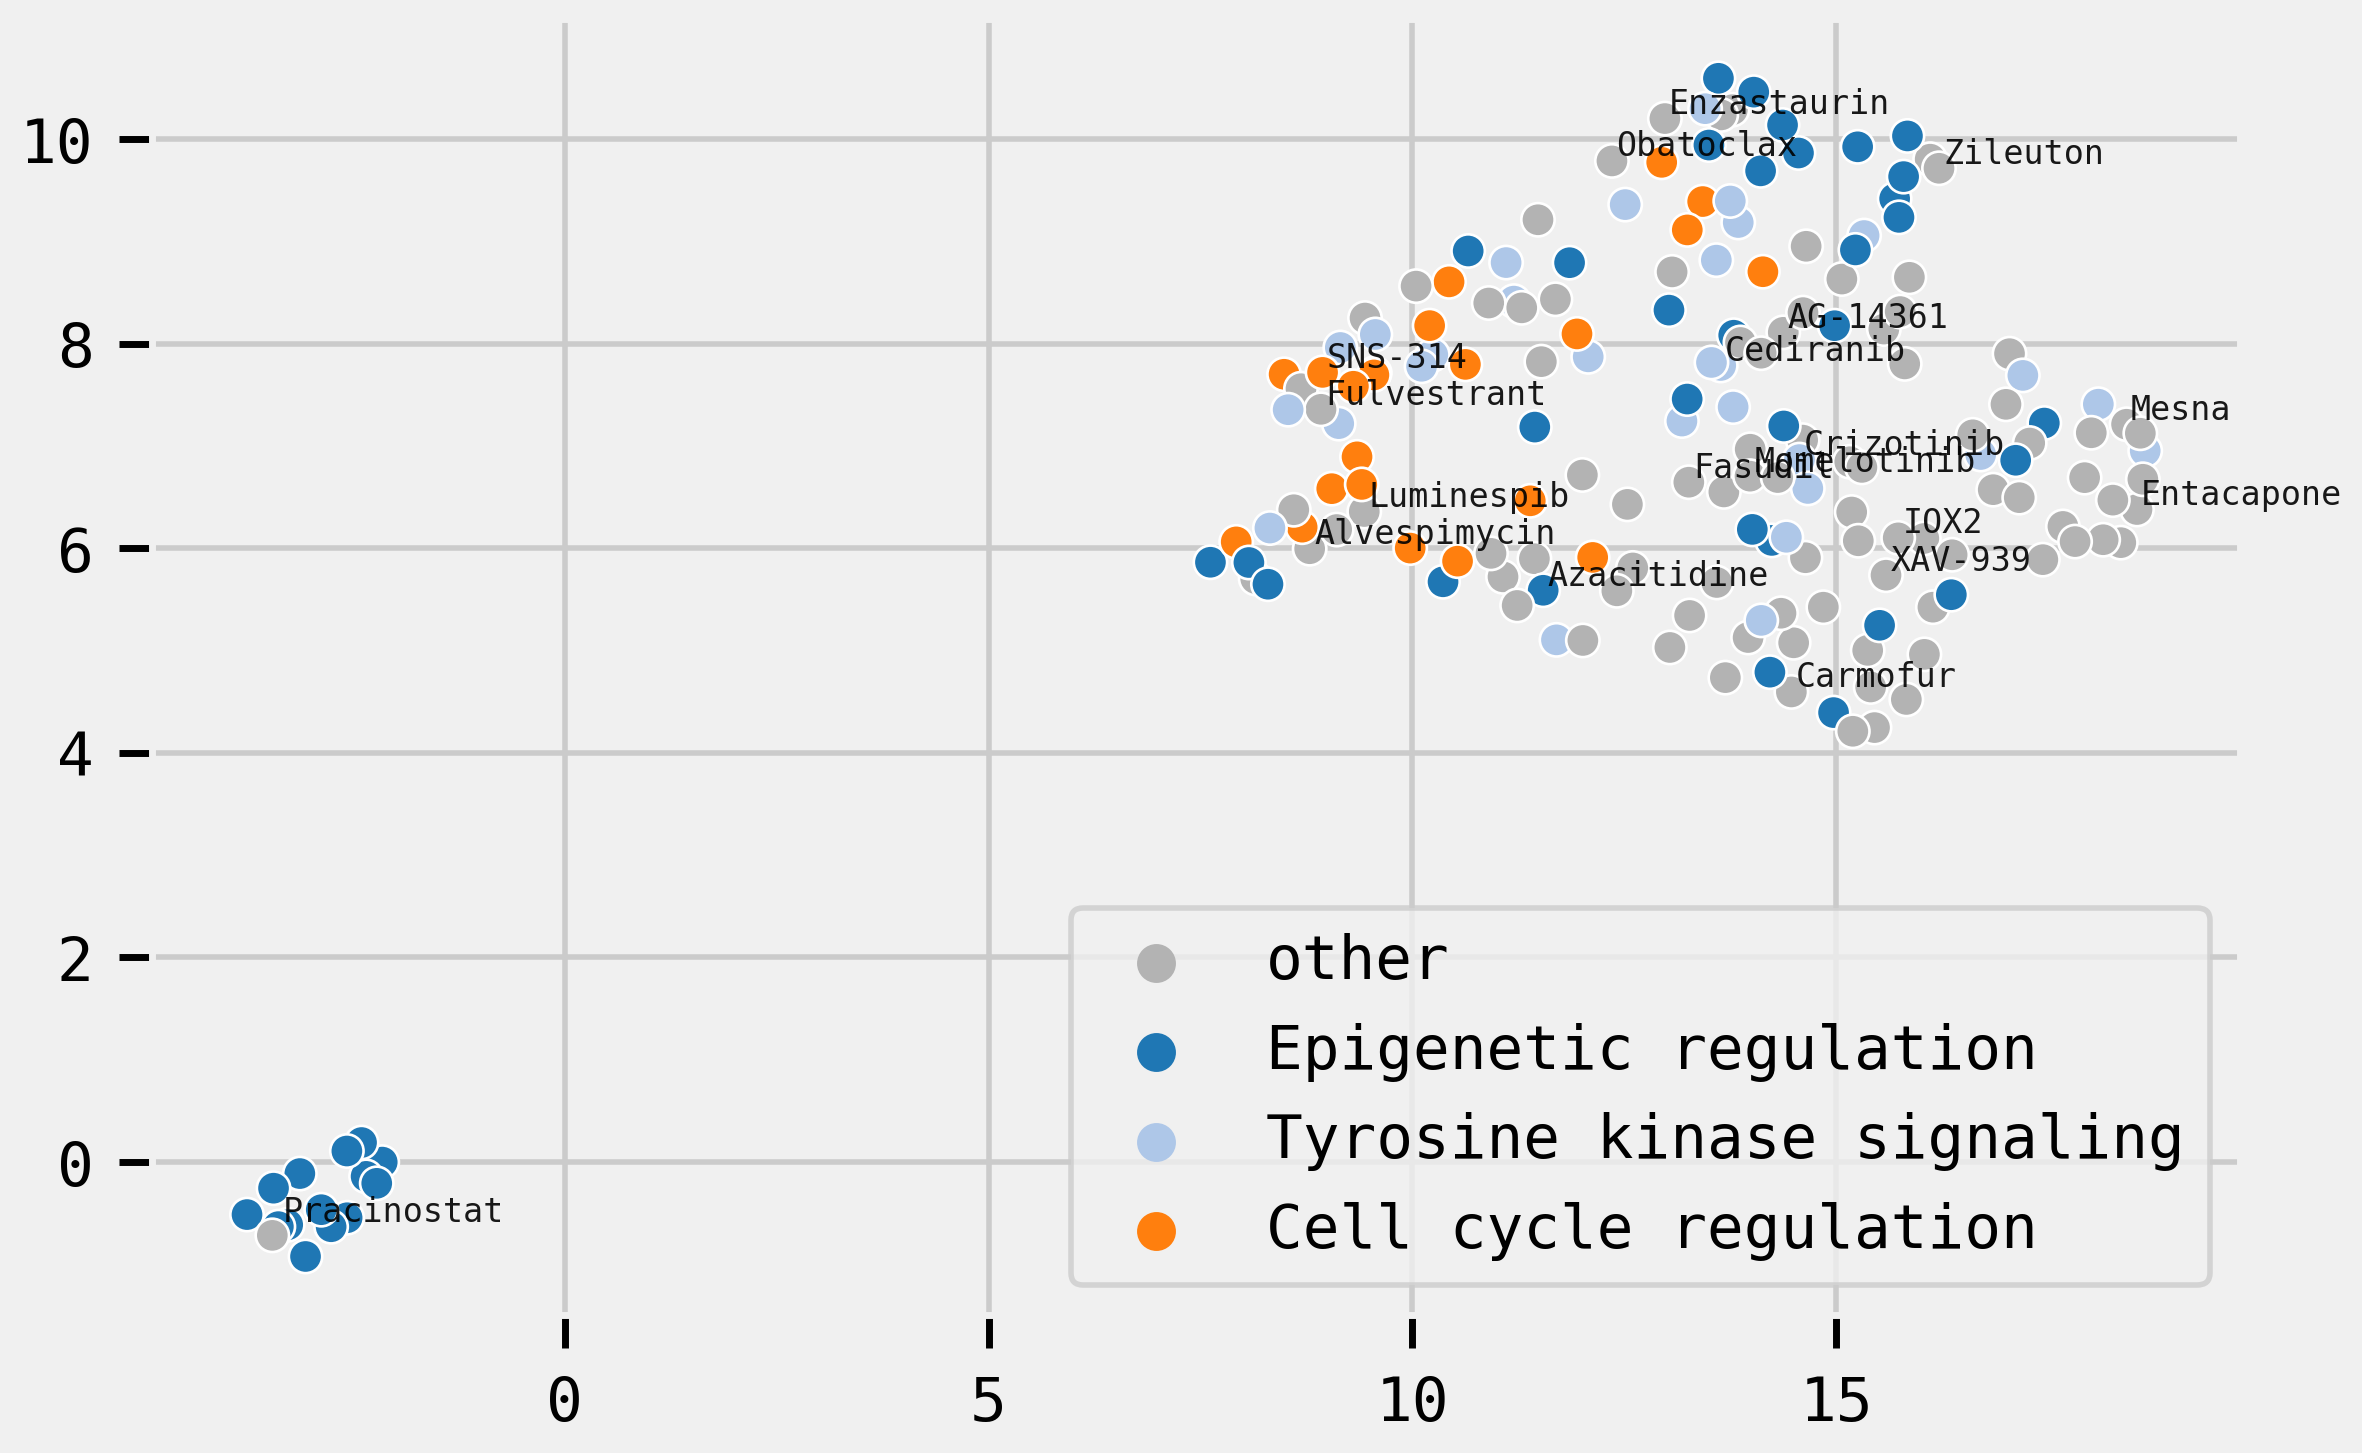

In [34]:
plot_umap(
    mapper_pretrained,
    canon_smiles_unique_sorted, 
    smiles_to_pathway_map, 
    smiles_to_drug_map,
    groups = ["Epigenetic regulation", "Tyrosine kinase signaling", "Cell cycle regulation"],
    ood_drugs=ood_drugs
)

plt.savefig(FIGURE_DIR/'UMAP_embedding_pretrained.eps', format='eps', bbox_inches='tight')

___
___
## Non-pretrained model

### Load model

In [20]:
config = load_config(seml_collection, model_hash_scratch)
dataset, key_dict = load_dataset(config)
config['dataset']['n_vars'] = dataset.n_vars
canon_smiles_unique_sorted, smiles_to_pathway_map, smiles_to_drug_map = load_smiles(config, dataset, key_dict)
model_scratch, embedding_scratch = load_model(config, canon_smiles_unique_sorted)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

### Compute UMAP

In [21]:
transf_embeddings_scratch = compute_drug_embeddings(model_scratch, embedding_scratch)
mapper_scratch = umap.UMAP(n_neighbors=25, min_dist=0.5).fit_transform(transf_embeddings_scratch)

### Plot UMAP

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


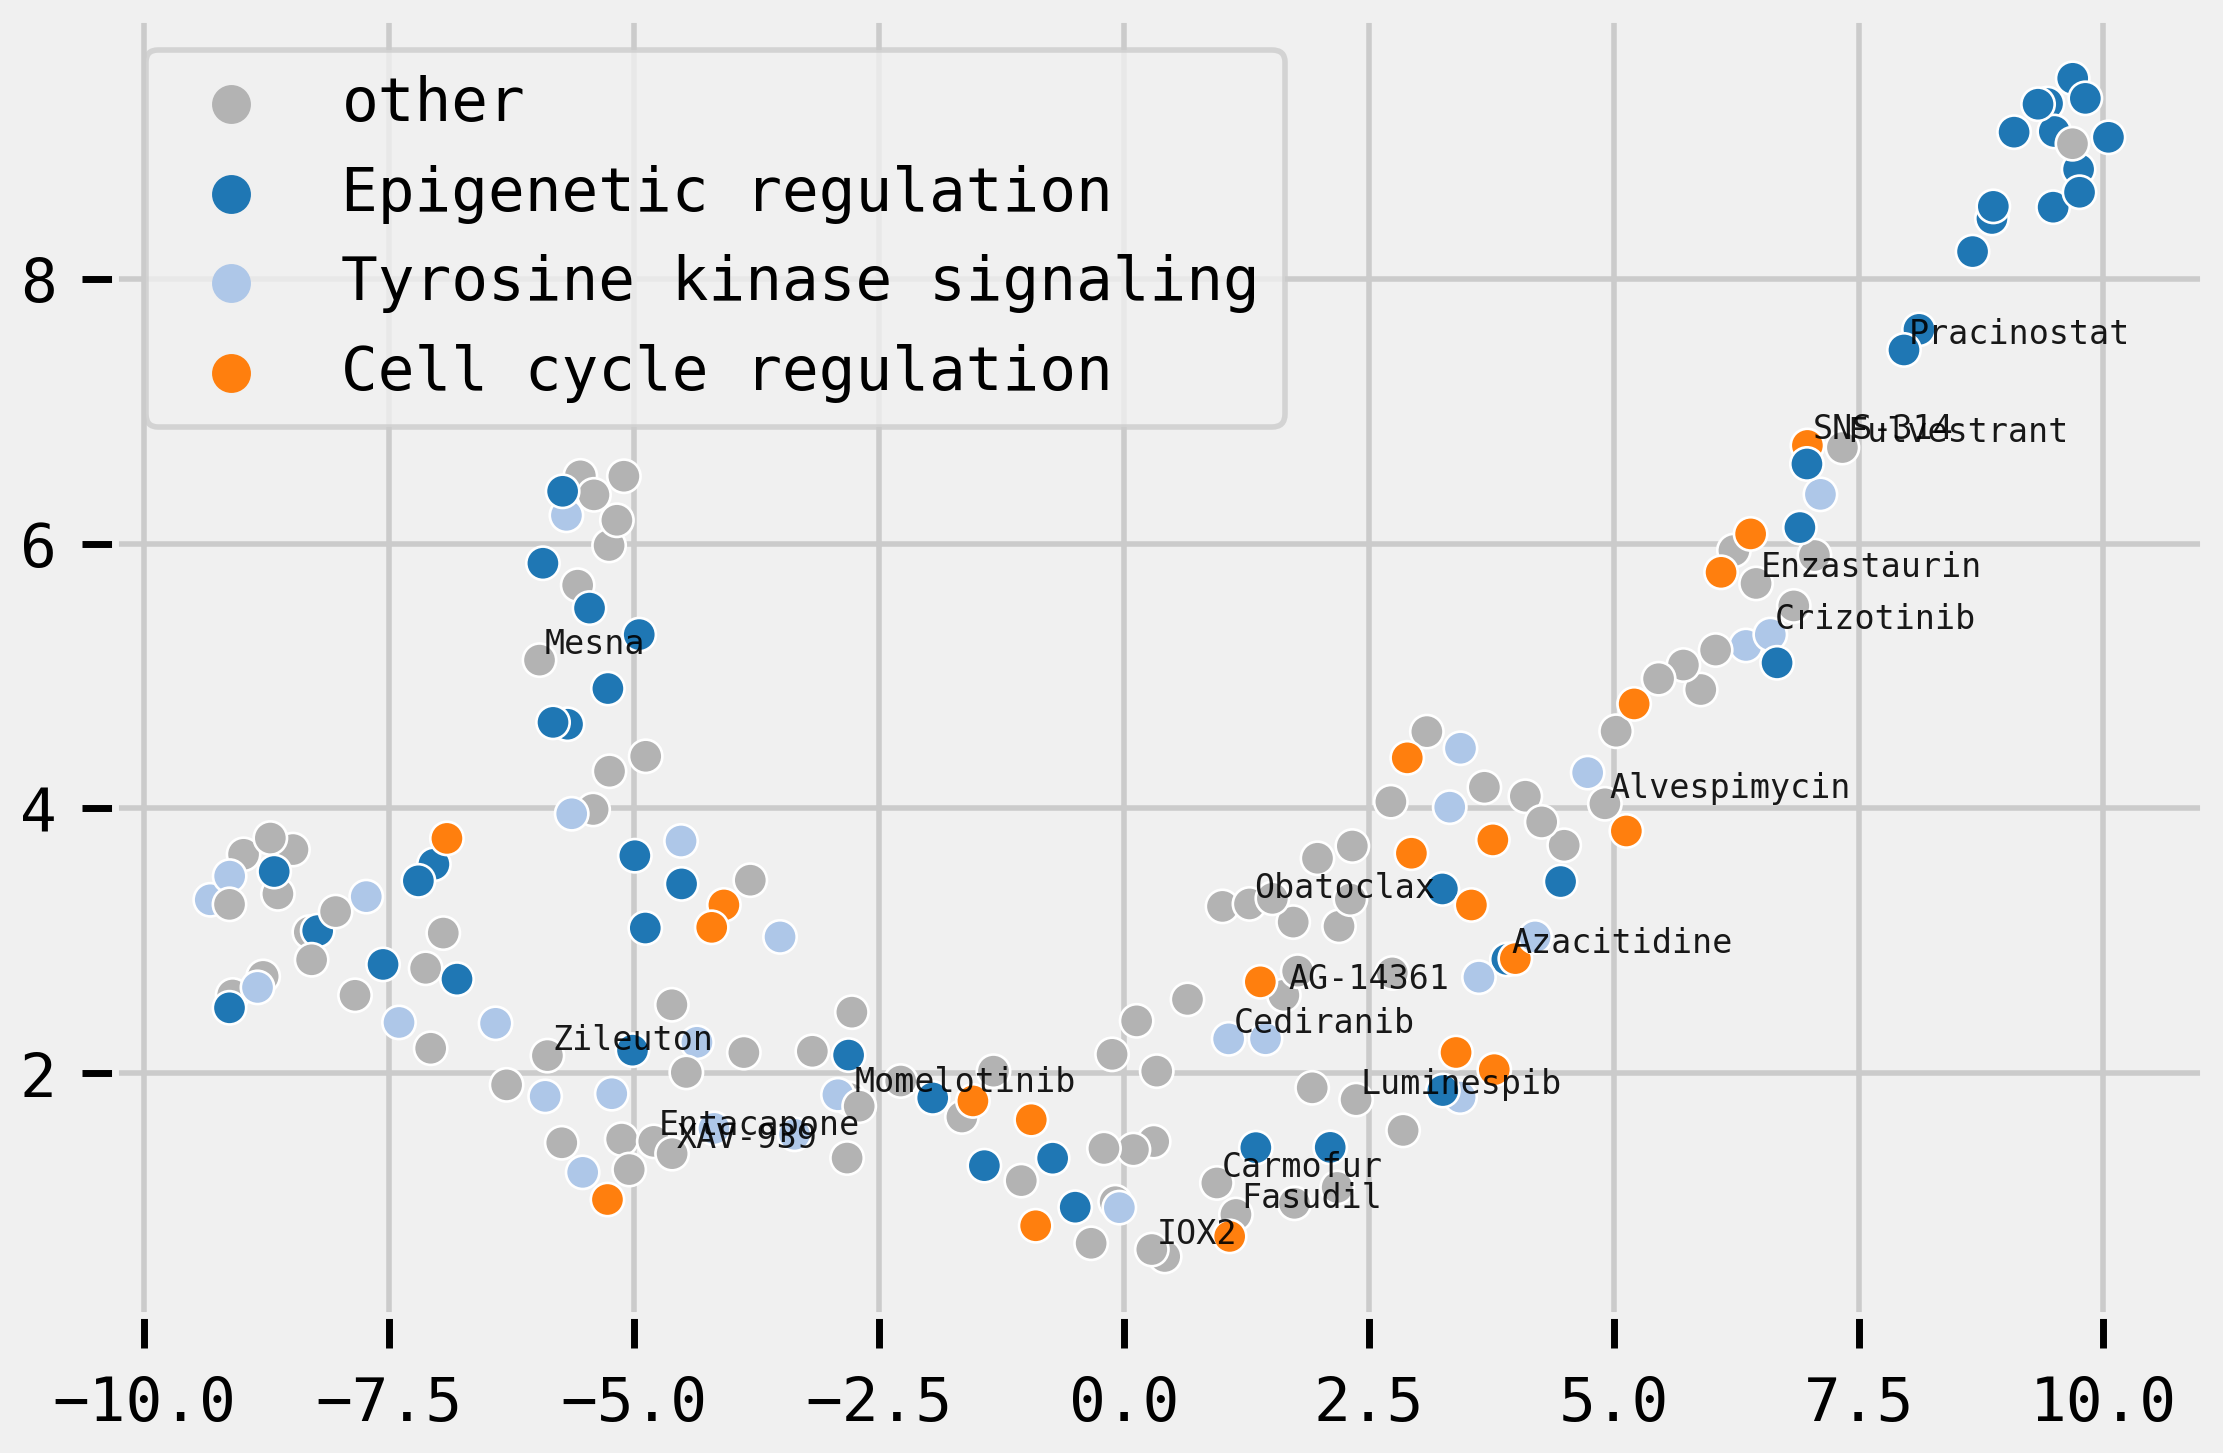

In [33]:
plot_umap(
    mapper_scratch,
    canon_smiles_unique_sorted, 
    smiles_to_pathway_map, 
    smiles_to_drug_map,
    groups = ["Epigenetic regulation", "Tyrosine kinase signaling", "Cell cycle regulation"],
    ood_drugs=ood_drugs
)

plt.savefig(FIGURE_DIR/'UMAP_embedding_scratch.eps', format='eps', bbox_inches='tight')

In [ ]:
# from compert.data import load_dataset_splits

# data_params = config['dataset']['data_params']
# data_params['split_key'] = 'split_ho_epigenetic'
# datasets = load_dataset_splits(**data_params, return_dataset=False)

In [ ]:
# datasets

In [ ]:
# predictions_dict = compute_pred(model, datasets['training'])

In [ ]:
# predictions_dict = compute_pred(model, datasets['ood']) # non-pretrained